In [1]:
! pip install -q bertopic datasets gensim


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from umap import UMAP
from gensim.models.poincare import PoincareModel
from nltk.corpus import wordnet as wn
import nltk
import csv
import os
import itertools
from tqdm import tqdm
import random
from gensim.models.poincare import LinkPredictionEvaluation, ReconstructionEvaluation
import pandas as pd

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
OUTPUT_DIR = "outputs"

In [4]:

dataset = load_dataset("tweet_eval", "offensive")

In [5]:
# TODO Do a prettier print of the dataset dictionary
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})

In [6]:
# do a pretty of sample train dataset
train_ds = dataset["train"]
train_ds[0]

{'text': '@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.',
 'label': 0}

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/class_frequency.png'

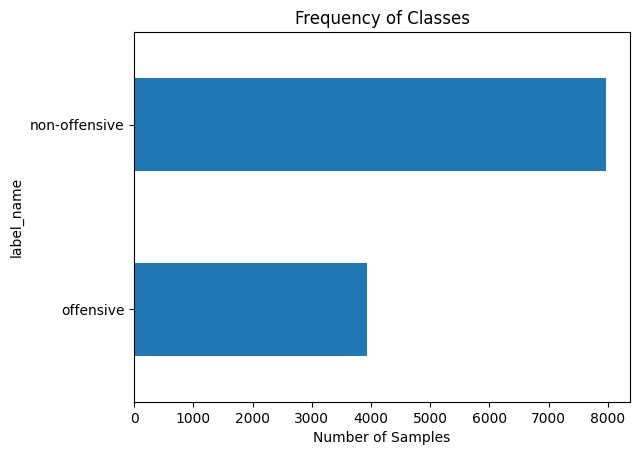

In [7]:

dataset.set_format(type="pandas")
df = dataset["train"][:]

def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.xlabel("Number of Samples")
plt.title("Frequency of Classes")
plt.savefig(os.path.join(OUTPUT_DIR, "class_frequency.png"))
plt.show()

In [26]:

umap_model = UMAP(random_state=42)

topic_model = BERTopic(umap_model=umap_model)

In [27]:
train_docs = dataset["train"]['text']
train_classes = dataset["train"]['label']
test_docs = dataset["test"]['text']
test_classes = dataset["test"]['label']
valid_docs = dataset["validation"]['text']
valid_classes = dataset["validation"]['label']

In [28]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, embedding_model="all-MiniLM-L6-v2")
topics, probs = topic_model.fit_transform(train_docs)

Batches: 100%|██████████| 373/373 [02:34<00:00,  2.41it/s]
2023-11-02 10:41:10,379 - BERTopic - Transformed documents to Embeddings


In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4977,-1_is_you_to_the,"[is, you, to, the, he, and, are, she, of, user]",[@user She is really good for him and told him...
1,0,1013,0_gun_control_guns_laws,"[gun, control, guns, laws, about, the, in, nra...",[.@USER ..... But But But all those gun contro...
2,1,349,1_liberals_they_liberal_their,"[liberals, they, liberal, their, user, are, th...","[@user Liberals be like, @user @user @user @us..."
3,2,283,2_antifa_your_user_like,"[antifa, your, user, like, member, one, member...","[@user @user That would be Antifa!, @user Like..."
4,3,203,3_conservatives_conservative_they_the,"[conservatives, conservative, they, the, are, ...","[@user all conservatives are bad people, @user..."
...,...,...,...,...,...
126,125,11,125_drink_drunk_sober_alcohol,"[drink, drunk, sober, alcohol, tense, inherit,...","[@user I can't drink., -- @user in the sitting..."
127,126,10,126_kavanaugh_defendthesecond_nra_2a,"[kavanaugh, defendthesecond, nra, 2a, gun, con...",[930 pm 3rd round: gun control whining and Sen...
128,127,10,127_carry_get_stealing_steal,"[carry, get, stealing, steal, someone, antifa,...",[@user I'm hoping it's a joke. #antifa are mor...
129,128,10,128_fool_fools_lol_suffer,"[fool, fools, lol, suffer, shiit, bisca, impat...","[@user fool, @user Fool, @user @user @user Sau..."


In [ ]:
topic_model.get_topic(0)

[('gun', 0.039722897401905474),
 ('control', 0.03645068800329309),
 ('guns', 0.013603459896491601),
 ('laws', 0.012974757296221925),
 ('about', 0.007531565546968854),
 ('the', 0.007460539005549443),
 ('in', 0.007058525725091209),
 ('nra', 0.00705520176299625),
 ('chicago', 0.007052810491563634),
 ('to', 0.0068424252428172325)]

In [ ]:
len(topic_model.get_topics().values())

131

In [ ]:
embeddings = []
for topic in topic_model.get_topics().values():
    topic_embeddings = []
    for i in range(len(topic) - 1):
        for j in range(i + 1, len(topic)):
            topic_embeddings.append([topic[j][0], topic[i][0]])
    embeddings.append(topic_embeddings)
print(embeddings[0])

[['you', 'is'], ['to', 'is'], ['the', 'is'], ['he', 'is'], ['and', 'is'], ['are', 'is'], ['she', 'is'], ['of', 'is'], ['user', 'is'], ['to', 'you'], ['the', 'you'], ['he', 'you'], ['and', 'you'], ['are', 'you'], ['she', 'you'], ['of', 'you'], ['user', 'you'], ['the', 'to'], ['he', 'to'], ['and', 'to'], ['are', 'to'], ['she', 'to'], ['of', 'to'], ['user', 'to'], ['he', 'the'], ['and', 'the'], ['are', 'the'], ['she', 'the'], ['of', 'the'], ['user', 'the'], ['and', 'he'], ['are', 'he'], ['she', 'he'], ['of', 'he'], ['user', 'he'], ['are', 'and'], ['she', 'and'], ['of', 'and'], ['user', 'and'], ['she', 'are'], ['of', 'are'], ['user', 'are'], ['of', 'she'], ['user', 'she'], ['user', 'of']]


In [ ]:

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
flat_list = [item for sublist in embeddings for embedding in sublist for item in embedding]

# Get unique words
vocab = list(set(flat_list))
print(f'Voabulary size: {len(vocab)}')
print(f'Sample of vocabulary: {vocab[:5]}')

Voabulary size: 1019
Sample of vocabulary: ['carry', 'arnie', 'johny', 'strangers', 'growth']


In [ ]:
relations = []
def get_hypernym_relations(word, relations):
    """Get hypernym relations for a word."""
    for synset in wn.synsets(word):
        for hypernym in synset.hypernyms():
            hyp = [synset.lemmas()[0].name(), hypernym.lemmas()[0].name()]
            if len(hyp) != 0:
              relations.append(hyp)
    return relations

for v in vocab:
  get_hypernym_relations(f'{v}', relations)
print(f'Number of relations: {len(relations)}')

print(relations[:5])

Number of relations: 3656
[['carry', 'transportation'], ['transport', 'move'], ['carry', 'have'], ['impart', 'bring'], ['carry', 'communicate']]


In [ ]:

DATA_DIRECTORY = 'data'
test_size_ratio = 0.2
train_relation = relations[:int(len(relations) * (1 - test_size_ratio))]
test_relation = relations[int(len(relations) * (1 - test_size_ratio)):]
train_relation_file_path = os.path.join(DATA_DIRECTORY, 'train_relation.tsv')
test_relation_file_path = os.path.join(DATA_DIRECTORY, 'test_relation.tsv')
for (relations_set,relation_file_path) in zip([train_relation, test_relation], [train_relation_file_path, test_relation_file_path]):
  with open(relation_file_path, 'w') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    
    for row in relations:
        tsv_output.writerow(row)

In [ ]:

def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))


In [ ]:

parameters_grid = list(product_dict(epochs=[50], size=[5,10,20,50, 100, 200], negative=[5, 10, 20]))
models = []
for parameters in tqdm(parameters_grid):
    size = parameters['size']
    negative = parameters['negative']
    model = PoincareModel(relations, size=size, negative=negative)
    model.train(epochs=parameters['epochs'], print_every=1)

100%|██████████| 18/18 [05:11<00:00, 17.33s/it]


In [ ]:

type(model.kv)

gensim.models.poincare.PoincareKeyedVectors

In [ ]:

evaluation = LinkPredictionEvaluation(train_relation_file_path,test_relation_file_path, model.kv)
evaluation.evaluate()

{'mean_rank': 27.730616660656327, 'MAP': 0.3819613324532116}

In [ ]:

models_df = pd.DataFrame(parameters_grid)
models_df.head()